In [2]:
#Imports
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import os

In [14]:
#Deze functie wordt gebruikt om inline the image te kunnen tonen
def plot_with_matlib(image):
    rgb_image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(rgb_image)

# Exercise 1
Write a simple camera simulator that projects a 3D wireframe model to image coordinates.

## Question 1: What is the camera matrix for a 1080p camera with a horizontal field of view of 90 degrees?

So for a 1080p camera the dimensions would be (1920,1080). The camera calibration matrix has a form of:<br>
|f_x 0 p_x|<br>
|0 f_y p_y|<br>
|0 0    1 |<br>

f_x = the horizontal focal length<br>
f_y = the vertical focal length<br>

For a 1080p camera f_x = f_y:<br>
f_x = width / (2* tan(theta / 2))<br>
    = 1920 / (2 * tan(90/2))<br>
    = 1920 / (2*1)<br>
    = 960<br>

We assume that the principal point is in the center of the camera so: (960, 540)

So the result matrix would be:<br>
|960  0  960|<br>
| 0  960 540|<br>
| 0   0   1 |<br>


## Assignment 1:
- Create a virtual 3D cube with a side of 1 meter, defined as an 8x3 matrix containing the 3D coordinates
of the vertices of the cube relative to the camera (you can choose the exact position, picture the situation
in your head or make a quick freehand diagram), and a 12x2 array of edges described by pairs of vertex
indices that need to be connected by lines

![Cube drawing](./Images/Cube_image_lab3.png)

In [11]:
# Vertices
vertices = np.array([[1,1,1],[2,1,1],[1,2,1],[2,2,1],[1,2,2],[2,2,2],[1,1,2],[2,1,2]])

vertices[:,2] += 3

# Edges
edges = np.array([
    [0,1],[1,3],[3,2],[2,0], #front face
    [4,5],[5,7],[7,6],[6,4], #back face
    [2,4],[3,5],[1,7],[0,6] #connections of front and back
])


- Project the 3D vertex coordinates to 2D image coordinates using your camera matrix from Question
1, and visualize the result by drawing the vertices and edges on an empty 1080p image. Pay attention
to the dimensions of your matrices, transpose as necessary and round the image coordinates to integer
pixels.

used: https://ksimek.github.io/2013/08/13/intrinsic/

In [6]:
#Re-usable function 
def create_camera_matrix(res:tuple,fov:int) -> np.array:
    # Calculate the focal length in pixels using the horizontal FOV
    focal_length_pixels = res[0] / (2*np.tan(fov / 2))
    # Calculate the camera matrix
    fx = fy = focal_length_pixels
    cx = res[0] / 2
    cy = res[1] / 2
    camera_matrix = np.array([[fx, 0, cx],
                            [0, fy, cy],
                            [0, 0, 1]])
    
    return camera_matrix

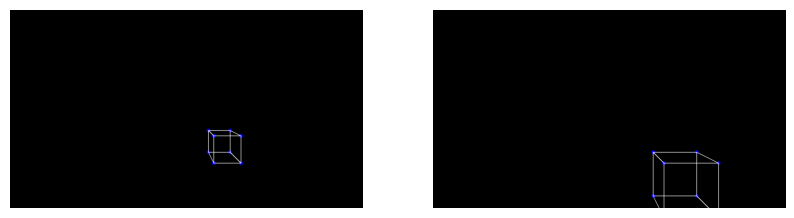

In [12]:
resolution = (1920, 1080)  # 1080p resolution
fov_horizontal_degrees = 90 

K = create_camera_matrix(resolution,fov_horizontal_degrees)
K_double = K.copy()
K_double[0][0] *=2
K_double[1][1] *= 2

image_coord = np.dot(K,vertices.T).T
image_coord2 = np.dot(K_double,vertices.T).T

for i in range(image_coord.shape[0]):
    image_coord[i, 0] /= image_coord[i, 2]  # Normalize x-coordinate
    image_coord2[i, 0] /= image_coord2[i, 2]  # Normalize x-coordinate
    image_coord[i, 1] /= image_coord[i, 2]  # Normalize y-coordinate
    image_coord2[i, 1] /= image_coord2[i, 2]  # Normalize y-coordinate
    
image_coord = np.round(image_coord[:, :2]).astype(int)
image_coord2 = np.round(image_coord2[:, :2]).astype(int)

image = np.zeros((1080, 1920, 3), dtype=np.uint8)
image2 = np.zeros((1080, 1920, 3), dtype=np.uint8)


for point in image_coord:
    cv.circle(image, tuple(point), 10, (0, 0, 255), -1)
    
for point in image_coord2:
    cv.circle(image2, tuple(point), 10, (0, 0, 255), -1)

for edge in edges:
    cv.line(image, tuple(image_coord[edge[0]]), tuple(image_coord[edge[1]]), (255, 255, 255), 2)
    cv.line(image2, tuple(image_coord2[edge[0]]), tuple(image_coord2[edge[1]]), (255, 255, 255), 2)

fig = plt.figure(figsize=(10,7))

fig.add_subplot(1,2,1)
plt.imshow(image)
plt.axis('off')
fig.add_subplot(1,2,2)
plt.imshow(image2)
plt.axis('off')

plt.show()
     

## Question 2: If you double the focal distance, what happens to the picture?

You zoom in. 

## Question 3: Why are there only even powers in this polynomial in r?

Multiple reasons, but the most promising one seems for computational performance. Using only even powers we no longer have to calculate the square root (this gets canceled out). Making it far more performant for computers to do these calculations. Odd powers are allowed, but will not necessarily improve accuracy meaning that the trade of for making it slower is not worth it.

# Exercise 2

## Assignment 2: Determine the intrinsic matrix and distortion parameters of the gopro camera used to shoot the calibration sequence you find on Ufora as calibration frames.zip. 
Print the matrix and coefficients in your report.

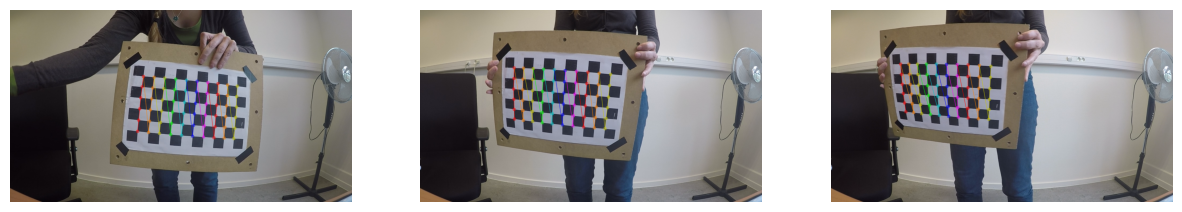

In [55]:
grid = (10,6)
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros(((grid[0])*(grid[1]),3), np.float32)
objp[:,:2] = np.mgrid[0:grid[1],0:grid[0]].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = os.listdir("./calibration_frames/")
del images[0]
del images[0]
count = 0

fig, axs = plt.subplots(1, 3, figsize=(15, 3))
for fname in images:
    img = cv.imread(f"./calibration_frames/{fname}")
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, (grid[1], grid[0]), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)
        
        # Draw and display the corners
        if count  < 3:
            cv.drawChessboardCorners(img, (grid[1], grid[0]), corners2, ret)
            axs[count].imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
            axs[count].axis('off')
            count += 1

plt.show()

In [56]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print(mtx)


[[582.03627379   0.         644.9351342 ]
 [  0.         585.89299199 340.65638727]
 [  0.           0.           1.        ]]


In [57]:
print(mtx)
print(dist)

[[582.03627379   0.         644.9351342 ]
 [  0.         585.89299199 340.65638727]
 [  0.           0.           1.        ]]
[[-2.35943791e-01  6.21780564e-02 -1.52685986e-03 -1.49302015e-04
  -8.04272922e-03]]


## Assignment 3: Do the calibration procedure for different random subsets of 20 frames. Print the standard deviation across these calibration experiments on each of the parameters

In [62]:

# Function to perform calibration and return the parameters
def calibrate(images, grid, criteria, objp):
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    for fname in images:
        img = cv.imread(f"./calibration_frames/{fname}")
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, (grid[1], grid[0]), None)
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)
    # Perform calibration
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


    #fx, fy, cx, cy, distortioncoef
    return mtx[0][0],mtx[1][1],mtx[0][2],mtx[1][2],dist

# Parameters
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
objp = np.zeros(((grid[0])*(grid[1]), 3), np.float32)
objp[:,:2] = np.mgrid[0:grid[1],0:grid[0]].T.reshape(-1,2)
images = os.listdir("./calibration_frames/")
del images[0]
del images[0]
# Number of calibration experiments
num_experiments = 10
fx_list = []
fy_list = []
cx_list = []
cy_list = []
dist_list = []
for _ in range(num_experiments):
   
    selected_images = np.random.choice(images,20, replace=False)
    fx, fy, cx, cy, coef= calibrate(selected_images, grid, criteria, objp)
    fx_list.append(fx)
    fy_list.append(fy)
    cx_list.append(cx)
    cy_list.append(cy)
    dist_list.append(coef)



In [66]:
print("Standard deviation across calibration experiments:")
fx_list = np.array(fx_list)
fy_list = np.array(fy_list)
cx_list = np.array(cx_list)
cy_list = np.array(cy_list)

print(f"STD for fx: {np.std(fx_list)}")
print(f"STD for fy: {np.std(fy_list)}")
print(f"STD for cx: {np.std(cx_list)}")
print(f"STD for cy: {np.std(cy_list)}")

Standard deviation across calibration experiments:
STD for fx: 618.8610235821839
STD for fy: 400.370168848671
STD for cx: 24.733304353189496
STD for cy: 18.352240691790566


In [67]:
fx_list

array([1134.60514181, 2751.45153027,  565.52822467,  678.13537617,
        584.20053979,  819.80368599, 1056.67914577,  657.37708736,
        788.43000826,  703.56628364])

## Assignment 4: Use your best calibration result to undistort one of the frames from the sequence. Lines that are straight in reality should be straight in your rectified image now.

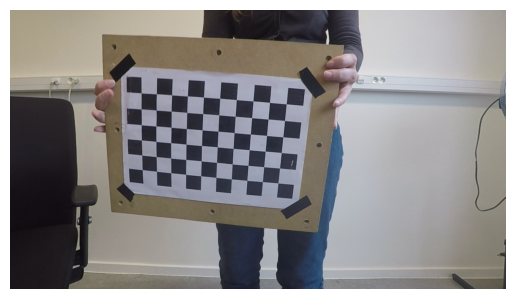

In [68]:
mean_fx = np.median(fx_list)
mean_fy = np.median(fy_list)
mean_cx = np.median(cx_list)
mean_cy = np.median(cy_list)


differences = np.abs(fx_list - mean_fx)
closest_index = differences.argmin()
best_fx =  fx_list[closest_index]
best_fy = fy_list[closest_index]
best_cx = cx_list[closest_index]
best_cy = cy_list[closest_index]

distorted_img = cv.imread('./calibration_frames/img_0004.png')

camera_matrix = np.array([
    [best_fx,0,best_cx],
    [0,best_fy,best_cy],
    [0,0,1]
])

# undistort
result = cv.undistort(distorted_img, camera_matrix, dist_list[closest_index], None, camera_matrix)

plot_with_matlib(result)

# Exercise 3

## Assignment 5 Shear shadow.png so that the photographer’s shadow becomes vertical. Size your target image so that it will be large enough to accommodate the sheared image, and make sure that all parts of the original image are visible. You can add translation by placing pixel offsets in the third column.

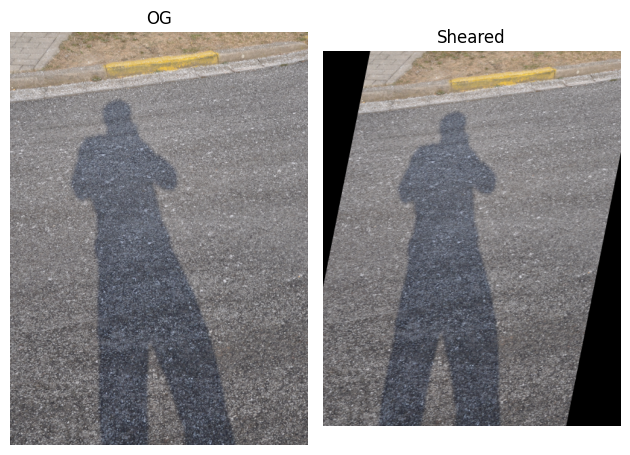

In [51]:
shadow_img = cv.imread("./images/shadow.png")
m = -0.2
dx = 70
shear_matrix = np.array([
    [1, m ,dx],
    [0 , 1, 0]
])

result_img_shadow = cv.warpAffine(shadow_img,shear_matrix,(int(shadow_img.shape[1]*1.1),shadow_img.shape[0]))

fig, axes = plt.subplots(1, 2)

axes[0].imshow(cv.cvtColor(shadow_img, cv.COLOR_BGR2RGB))
axes[0].axis('off') 
axes[0].set_title('OG') 

axes[1].imshow(cv.cvtColor(result_img_shadow, cv.COLOR_BGR2RGB))
axes[1].axis('off')  
axes[1].set_title('Sheared')  


plt.tight_layout()
plt.show()

## Assignment 6: Apply a perspective transform to shadow box.png so that the photographer in not only stands vertically, but is also proportionally correct. In your program you click on the 4 corners of the tetragon that you want to transform into a rectangle, after which the right perspective transformation is searched for and executed. In order to make an image display window clickable, you have to set a mouse callback function that is called anytime your mouse pointer interacts in some way with the window.

In [53]:
shadow_box = cv.imread('./Images/shadow_box.png')

corner_points = []
vertices_2d = np.array([[50,95],[250,95],[250,495],[50,495]])

#Order of corners to click: top_left, top_right,bottom_right,bottom_left

def mouse_callback(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:
        if len(corner_points) < 4:
            corner_points.append((x,y))
        
        if len(corner_points) == 4:
            transform = cv.getPerspectiveTransform(np.float32(corner_points),np.float32(vertices_2d))
            result_img = cv.warpPerspective(shadow_box,transform,(300,500))
            cv.imshow("result",result_img)

cv.imshow('shadow box',shadow_box)
cv.setMouseCallback('shadow box', mouse_callback)
cv.waitKey(0)

-1

## Question 4: If you were to specify more than 4 points, the system would be overdetermined. How can you solve such an overdetermined system?

Using the least square minimization solution


## Question 5: Can you find an opencv function that takes more than 4 points?

cv.findHomography(	srcPoints, dstPoints[, method[, ransacReprojThreshold[, mask[, maxIters[, confidence]]]]]	) ->	retval, mask